# Exploration of the boulder database
  
Goal: Understanding the boulders database, trying to find patterns/groups/potential prediction in the dataset.

## Session declaration

In [11]:
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

DB_URL = "sqlite:///bleau_info.db"

engine = create_engine(DB_URL, echo=False)

session = Session(engine)

In [12]:
from sqlalchemy import select, func
from sqlalchemy.orm import joinedload
from models.boulder import Boulder
from models.repetition import Repetition


boulders = (
    session.execute(
        select(Boulder, func.count(Repetition.user_id))
        .options(
            joinedload(Boulder.styles),
            joinedload(Boulder.grade),
            joinedload(Boulder.slash_grade),
        )
        .outerjoin(Repetition)
        .group_by(Boulder.id)
    )
    .unique()
    .all()
)
print(boulders[2])

(<Boulder(name: Bélial, grade: 8b+, rating: 4.5, styles: [<Style(style: mur)>, <Style(style: aplats)>, <Style(style: réglettes)>]>, 4)


In [13]:
import pandas as pd


records = [
    {
        "id": boulder.id,
        "name": boulder.name,
        "area_id": boulder.area_id,
        "grade": boulder.grade.correspondence,
        "slash_grade": boulder.slash_grade.correspondence if boulder.slash_grade else None,
        "styles": [s.style for s in boulder.styles],
        "rating": boulder.rating,
        "ascents": ascents,
    }
    for (boulder, ascents) in boulders
]
df = pd.DataFrame(data=records)
display(df)

,id,name,area_id,grade,slash_grade,styles,rating,ascents
0,1,Hypothèse (assis),1,32,NaN,"[dévers, départ assis]",NaN,0
1,2,Digitale (assis),1,0,NaN,[mur],5.0,1
2,3,Bélial,1,30,31.0,"[mur, aplats, réglettes]",4.5,4
3,4,Rien ne Va Plus,1,30,NaN,"[dévers, départ assis, traversée]",NaN,0
4,5,Encore,1,29,NaN,"[boucle, surplomb]",NaN,2
...,...,...,...,...,...,...,...,...
40230,40231,La Rainure (en traversée),289,15,NaN,"[départ assis, aplats, traversée g-d]",1.7,2
40231,40232,Les Oreilles du Serpent,289,13,NaN,"[aplats, réta, bidoigts]",3.5,1
40232,40233,Ras des Feuilles,289,15,NaN,"[départ assis, aplats, bombé]",2.0,2
40233,40234,Chauffe-Serpent,289,8,NaN,"[bombé, trous]",2.5,1


In [14]:
df.drop(columns= ['id', 'name', 'slash_grade', 'area_id'], inplace=True)
display(df)

,grade,styles,rating,ascents
0,32,"[dévers, départ assis]",NaN,0
1,0,[mur],5.0,1
2,30,"[mur, aplats, réglettes]",4.5,4
3,30,"[dévers, départ assis, traversée]",NaN,0
4,29,"[boucle, surplomb]",NaN,2
...,...,...,...,...
40230,15,"[départ assis, aplats, traversée g-d]",1.7,2
40231,13,"[aplats, réta, bidoigts]",3.5,1
40232,15,"[départ assis, aplats, bombé]",2.0,2
40233,8,"[bombé, trous]",2.5,1


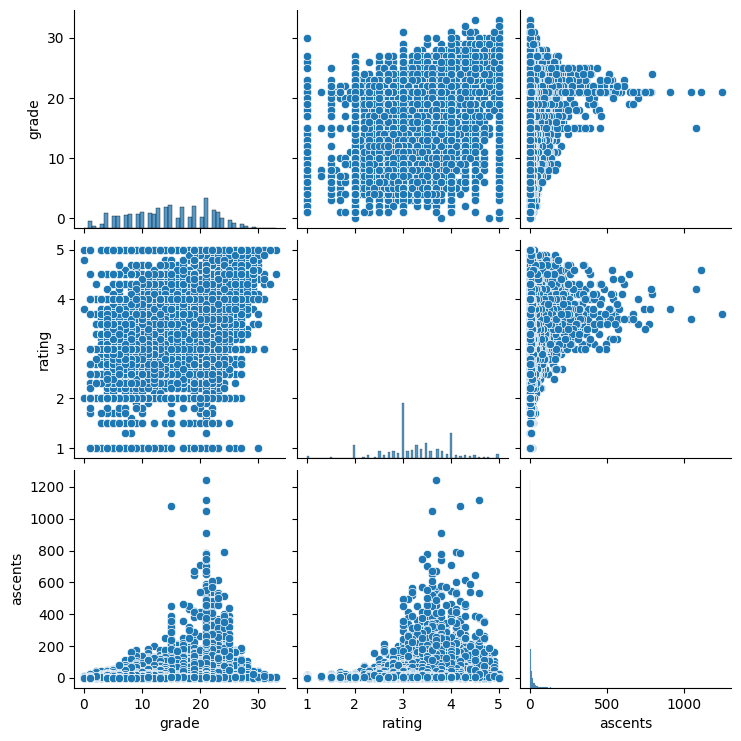

In [15]:
import seaborn as sns

sns.pairplot(data=df)

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
styles_encoded = mlb.fit_transform(df.styles)
styles_df = pd.DataFrame(styles_encoded, columns=mlb.classes_)

df = pd.concat([df.drop(columns='styles'), styles_df], axis=1)
display(df)

,grade,rating,ascents,aplats,arête,avec corde,bidoigts,bombé,boucle,cheminée,dalle,descente,dièdre,départ assis,dévers,expo,fissure,haut,inversées,jeté,monodoigts,mur,pilier,pincettes,proue,réglettes,réta,saut,surplomb,toit,traversée,traversée d-g,traversée g-d,trous
0,32,NaN,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,30,4.5,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,30,NaN,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,29,NaN,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40230,15,1.7,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
40231,13,3.5,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
40232,15,2.0,2,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40233,8,2.5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Trying to find a patern in the data (unsupervised learning)

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df_clean = df.dropna().copy()

kmeans = KMeans(n_clusters=3, random_state=1)
prediction = kmeans.fit_predict(df_clean)
score = -kmeans.score(df_clean)
silhouette = silhouette_score(df_clean, prediction)

In [18]:
print(f"Silhouette: {silhouette}")
print(f"Score: {score}")

Silhouette: 0.8014413759340591
Score: 13108065.594156759


In [19]:
df_clean['cluster'] = kmeans.labels_
df_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns=df.columns)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(df_centers)

,grade,rating,ascents,aplats,arête,avec corde,bidoigts,bombé,boucle,cheminée,dalle,descente,dièdre,départ assis,dévers,expo,fissure,haut,inversées,jeté,monodoigts,mur,pilier,pincettes,proue,réglettes,réta,saut,surplomb,toit,traversée,traversée d-g,traversée g-d,trous
0,15.043643,3.251786,10.972283,0.117686,0.109547,7.919050e-04,0.005543,0.011087,1.935768e-03,2.947646e-03,0.148394,2.903652e-03,0.004751,0.259217,0.135372,0.047866,0.056137,0.023625,0.014474,0.029652,0.002288,0.299032,3.594369e-02,0.002816,0.047470,0.072855,0.076639,7.479103e-04,0.063748,0.035592,7.567092e-03,0.083414,0.096084,0.025869
1,20.839161,3.758042,458.335664,0.230769,0.139860,-4.336809e-19,0.006993,0.006993,0.000000e+00,-4.336809e-19,0.006993,-8.673617e-19,0.000000,0.370629,0.160839,0.027972,0.048951,0.013986,0.027972,0.097902,0.000000,0.167832,-6.938894e-18,0.013986,0.118881,0.020979,0.118881,-4.336809e-19,0.286713,0.146853,-2.602085e-18,0.020979,0.013986,0.020979
2,18.573324,3.550000,116.377793,0.180168,0.124302,6.505213e-19,0.013268,0.009078,5.204170e-18,6.983240e-04,0.066341,5.204170e-18,0.002095,0.350559,0.176676,0.020950,0.061453,0.016760,0.023045,0.067039,0.005587,0.265363,3.491620e-02,0.004888,0.085196,0.085894,0.099162,6.983240e-04,0.152933,0.075419,2.094972e-03,0.033520,0.032821,0.018855


c:\Users\charl\Documents\11_Code\Projet\Bleau_info_statistics\machine_learning\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
c:\Users\charl\Documents\11_Code\Projet\Bleau_info_statistics\machine_learning\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
c:\Users\charl\Documents\11_Code\Projet\Bleau_info_statistics\machine_learning\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
c:\Users\charl\Documents\11_Code\Projet\Bleau_info_statistics\machine_learning\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: KDE cannot be e

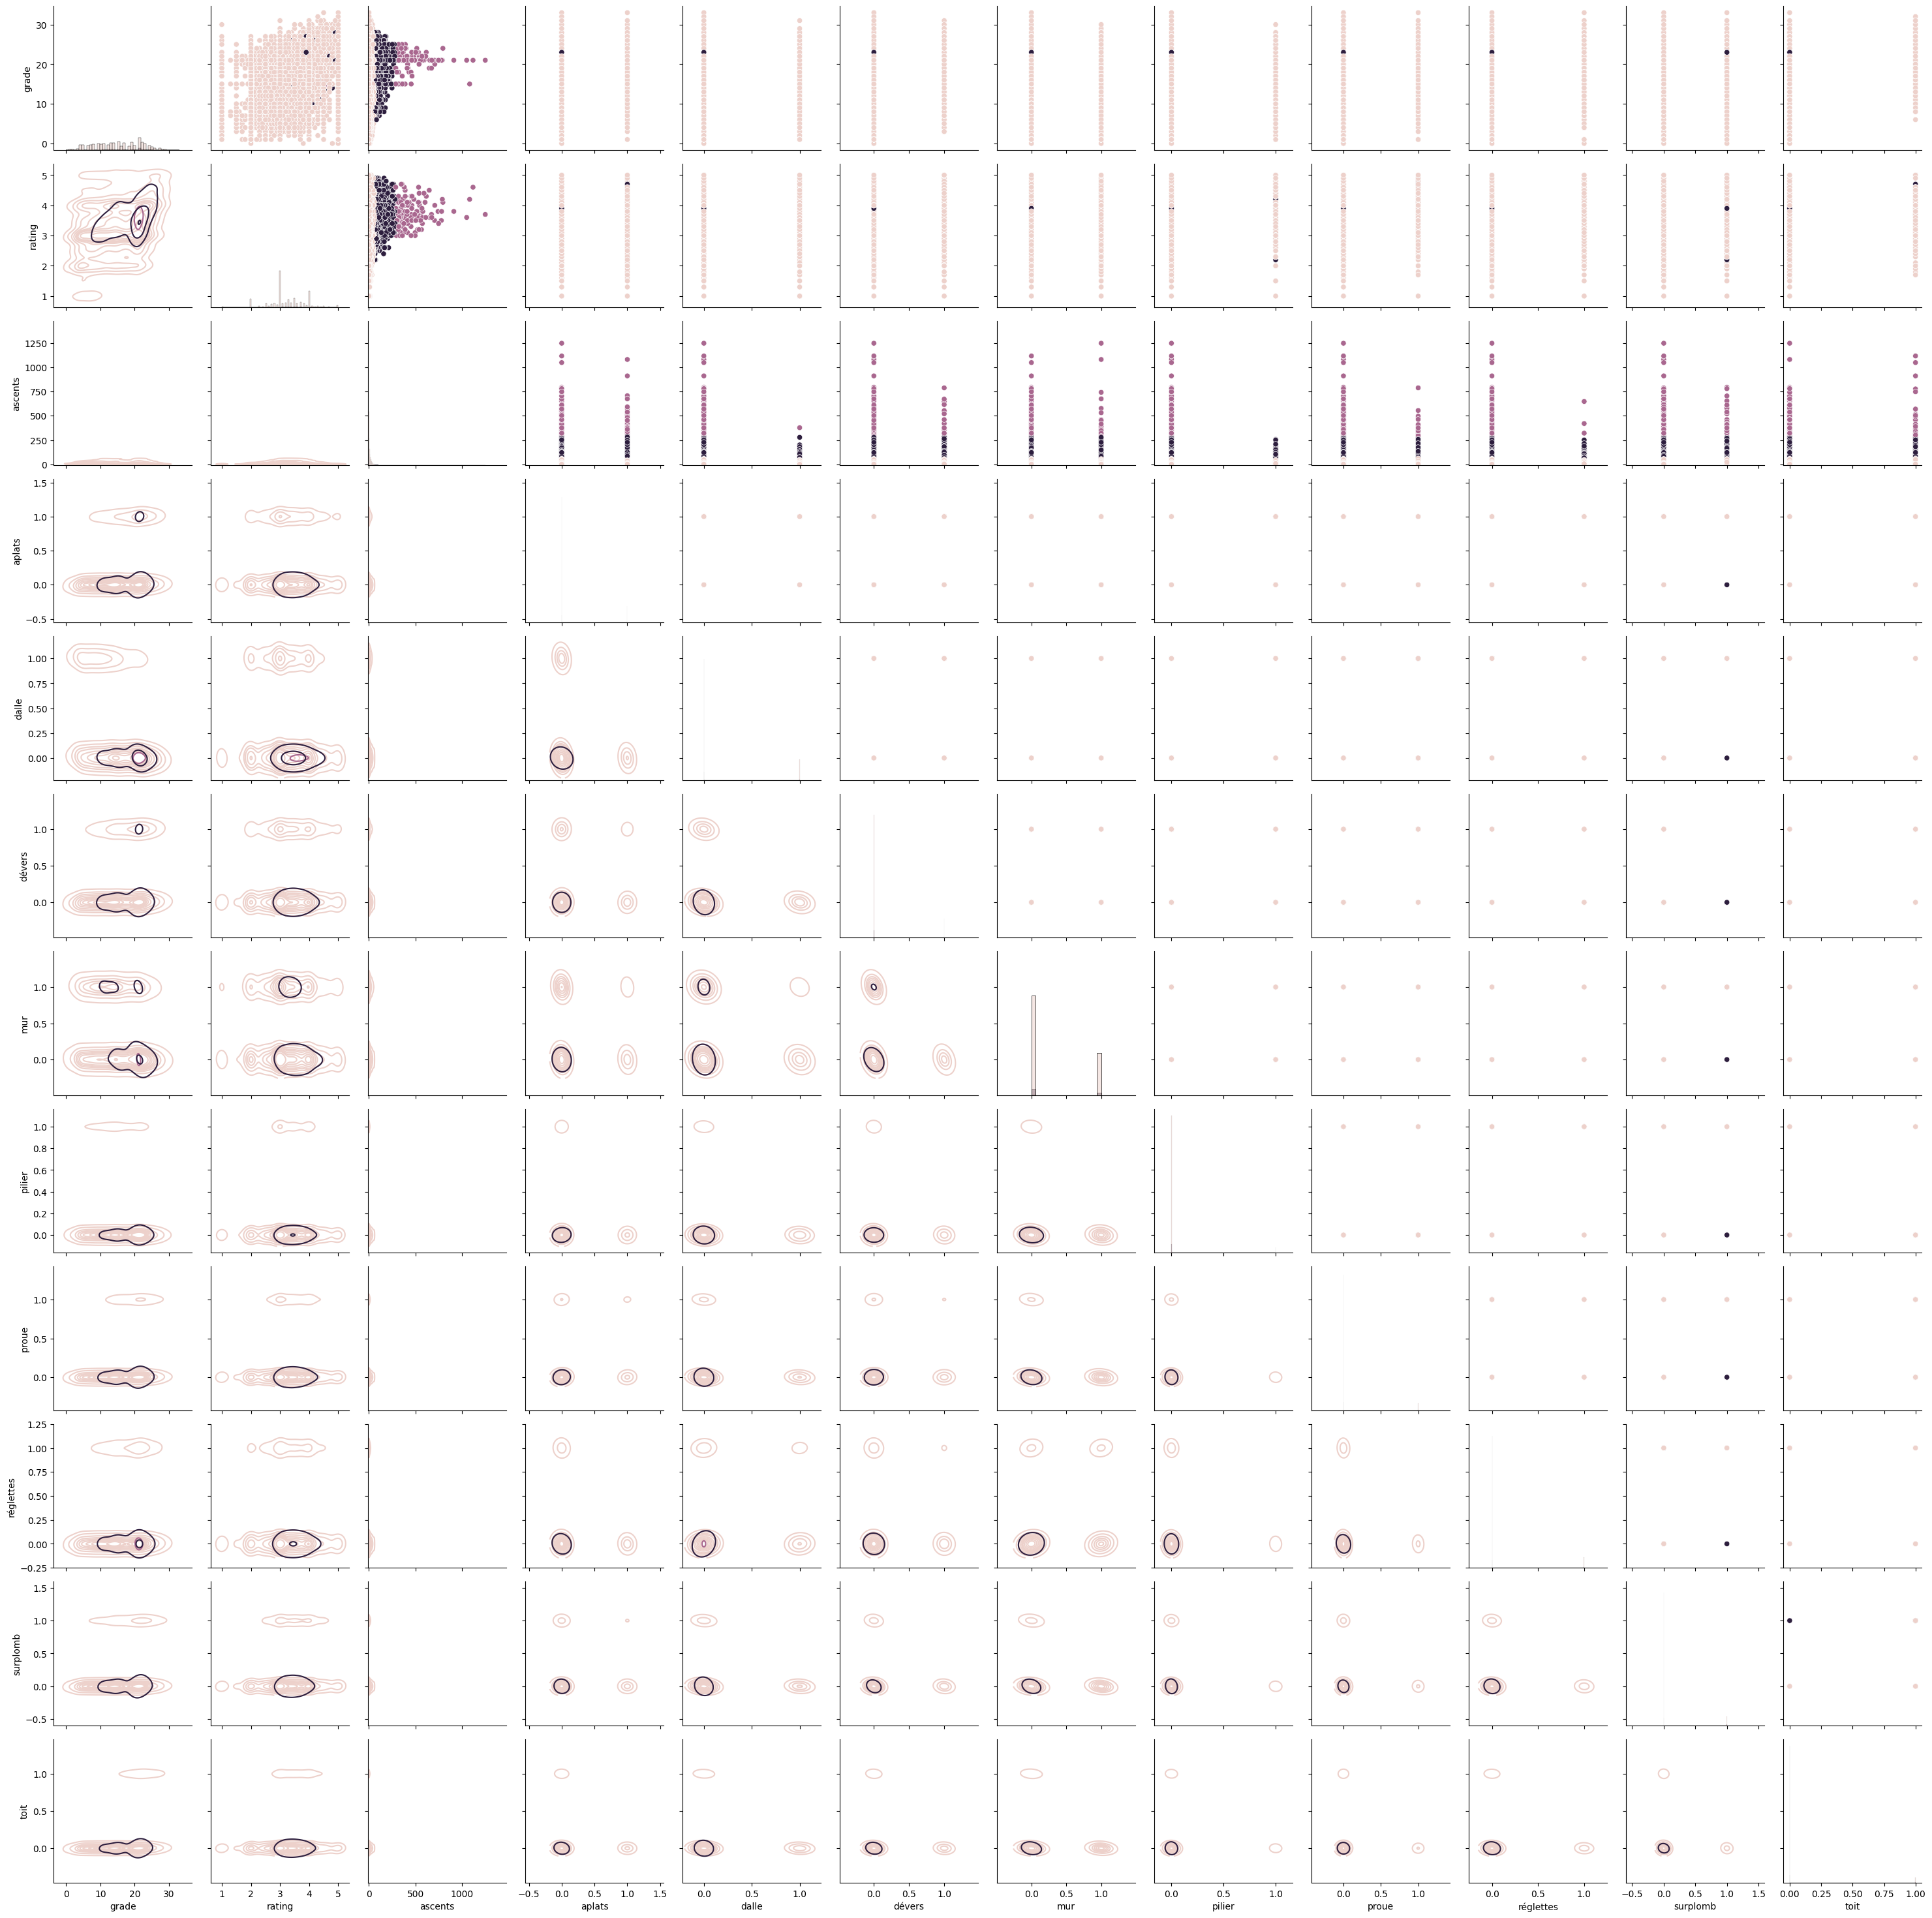

In [21]:
graph = sns.PairGrid(data=df_clean[['grade', 'rating', 'ascents', 'aplats', 'dalle', 'dévers', 'mur', 'pilier', 'proue', 'réglettes', 'surplomb', 'toit', 'cluster']], hue='cluster')
graph.map_lower(sns.kdeplot)
graph.map_upper(sns.scatterplot)
graph.map_diag(sns.histplot)